# Time-aware Attention-based RNN (TA-RNN)

In [37]:
# Import necessary libraries
import numpy as np
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import random
from keras.models import Sequential, Model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score,accuracy_score,f1_score,roc_auc_score
from keras.regularizers import l1, l2
from keras.layers import Bidirectional
from keras.layers import Dense, SimpleRNN, concatenate, Input, Flatten, Layer
from keras.layers import Dropout 
from keras.layers import LSTM, GRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Masking
import tensorflow as tf
import keras
import pickle
import math

# A customized binary cross entropy loss function
#𝐿𝑜𝑠𝑠 = −1/𝑁 ∑(𝛼 ∙ (𝑦 ∙ 𝑙𝑜𝑔 𝑦′)) + ((1 − 𝛼) ∙ (1 − 𝑦) ∙ 𝑙𝑜𝑔(1 − 𝑦′))

In [38]:
# to panelize positive (converter) misclassification
def binary_cross_entropy(y, yhat):
    epsilon = 0.7
    loss = -(tf.math.reduce_mean((epsilon * y * tf.math.log(yhat + 1e-6)) + ((1.0- epsilon) * (1 - y) * tf.math.log(1 - yhat + 1e-6)), axis=-1))
    return loss

# Time embedding layer

In [39]:
# Time embedding layer
class Time_embedding_layer(Layer):
    def __init__(self, d_model, max_seq_len):
        super(Time_embedding_layer, self).__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

    def get_time_encoding_table(self, max_seq_len, d_model, t_set):
        def reverse_min_max_normalization(normalized_value, min_val, max_val):
            original_value = normalized_value * (max_val - min_val) + min_val
            return original_value
            
        def cal_angle(el_time, hid_idx):
            el_time = reverse_min_max_normalization(el_time, 0.5, 5)
            return el_time / np.power(max_seq_len, 2 * (hid_idx // 2) / d_model)

        def get_timei_angle_vec(time_value):
            angels = [cal_angle(time_value, hid_j) for hid_j in range(d_model)]
            angels = tf.convert_to_tensor(angels, dtype=tf.float32)
            return angels

        time_encoding_matrix = tf.map_fn(lambda time_i: get_timei_angle_vec(time_i), t_set, fn_output_signature=tf.float32)
        
        # Calculate sine of the elements in dim 2i (even indices)
        sin_values = tf.math.sin(time_encoding_matrix[:, 0::2, :])
        
        # Calculate cosine of the elements in dim 2i+1 (odd indices)
        cos_values = tf.math.cos(time_encoding_matrix[:, 1::2, :])
        
        # Concatenate sin_values and cos_values and store them in time_encoding_matrix
        time_encoding_matrix = tf.concat([sin_values, cos_values], axis=1)
        
        return time_encoding_matrix

    def time_encoding(self, time_data):
        batch_size = tf.shape(time_data)[0]
        time_embedding = tf.zeros((batch_size, self.max_seq_len, self.d_model), dtype=tf.float32)
        time_embedding = self.get_time_encoding_table(self.max_seq_len, self.d_model, time_data)
        time_embedding = tf.transpose(time_embedding, perm=[0, 2, 1])
        return time_embedding
    
    def call(self, data_, time_):
        # Make embeddings relatively larger
        data_ = data_ * math.sqrt(self.d_model)
        time_embedding = self.time_encoding(time_)
        
        # Rearange the time embedding matrix even, odd... because sin and cos were concatenated previuosly.
        temp_data_even = time_embedding[:, :, 0::2]
        temp_data_odd = time_embedding[:, :, 1::2]
        arranged_time_embedding = tf.concat([temp_data_even, temp_data_odd], axis=-1)
        
        data_ = data_ + arranged_time_embedding
        return data_, arranged_time_embedding

# A dual-ttention layer (visits and features attention)

In [40]:
class AttentionLayer(Layer):
    def __init__(self, units, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # parameters to learn W1 and b1 for visits attention
        self.W1 = self.add_weight(name='W1', shape=(self.units, 1), initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(name='b1', shape=(1,), initializer='zeros', trainable=True)

        # parameters to learn W2 and b2 for features attention
        self.W2 = self.add_weight(name='W2', shape=(self.units, input_shape[-1][-1]), initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(name='b2', shape=(input_shape[-1][-1],), initializer='zeros', trainable=True)

        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs, mask=None):
        h, input_data = inputs

        # Calculate attention between visits
        # Apply mask to attention weights if mask is provided
        if mask is not None:
            # Ensure mask is broadcastable
            mask_broadcasted = tf.expand_dims(mask[0], axis=-1)
            h_masked = h * tf.cast(mask_broadcasted, tf.float32)
            e = tf.matmul(h_masked, self.W1) + self.b1
            e = tf.squeeze(e, axis=-1)
            alpha_unmasked = tf.nn.softmax(e, axis=-1)
            alpha_unmasked = tf.expand_dims(alpha_unmasked, axis=-1)
            alpha = alpha_unmasked * tf.cast(mask_broadcasted, tf.float32)
            alpha = alpha / tf.reduce_sum(alpha, axis=1, keepdims=True)

        else:
            e = tf.matmul(h, self.W1) + self.b1
            e = tf.squeeze(e, axis=-1)
            alpha = tf.nn.softmax(e, axis=-1)
            alpha = tf.expand_dims(alpha_unmasked, axis=-1)

        # Calculate attention between features in each visit
        # Apply mask to attention weights if mask is provided
        if mask is not None:
            # Ensure mask is broadcastable to beta_unmasked
            mask_broadcasted = tf.expand_dims(mask[0], axis=-1)
            h_masked = h * tf.cast(mask_broadcasted, tf.float32)
            beta_unmasked = tf.tanh(tf.matmul(h_masked, self.W2) + self.b2)
            beta_unmasked = tf.nn.softmax(beta_unmasked, axis=-1)
            beta = beta_unmasked * tf.cast(mask_broadcasted, tf.float32)
            #beta = beta / tf.reduce_sum(beta, axis=1, keepdims=True)
        else:
            beta = tf.tanh(tf.matmul(h, self.W2) + self.b2)
            beta = tf.nn.softmax(beta_unmasked, axis=-1)

        # Compute context vector
        if mask is not None:
            # Ensure mask is broadcastable to beta_unmasked
            mask_broadcasted = tf.expand_dims(mask[0], axis=-1)
            input_data_masked = input_data * tf.cast(mask_broadcasted, tf.float32)
            c = tf.reduce_sum(alpha * beta * input_data_masked, axis=1)
        else:
            c = tf.reduce_sum(alpha * beta * input_data, axis=1)
        

        return alpha, beta, c


    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][-1])

    def get_config(self):
        config = super().get_config().copy()
        config.update({'units': self.units})
        return config

# TA-RNN

In [41]:
# TA-RNN method that takes the follwing parametres:
# cell: it represents the RNN cell will be used {'GRU', 'biGRU', 'LSTM', 'biLSTM'}
# drout: it represents the drop out rate will be used {0, 0.1, 0.2, 0.3, 0.4, 0.5}
# L2: it represents the L2 regularization {0.1, 0.001, 0.00001, 0.0000001}
# ftp: it represents future time point to predict in PPAD its 1
# hidden_s: it represents the hidden size of RNN cell
# embedding_s: it represents the size of embedding data (in our case it will be the number of features)

def TA_RNN_with_demographic(cell, drout, L2, ftp, hidden_s, embedding_s):
    def masking_fun(tensor_data, mask_value):
        mask_tensor = tf.math.not_equal(tensor_data, mask_value)
        mask_tensor = mask_tensor[:,:,0:embedding_s]
        return mask_tensor
    
    # define the shape of the input for both time and longitudinal data
    input_data_shape = (time_steps, num_features_in_each_time_step)
    input_time_shape = (time_steps)

    # define the inputs for both data and elapced time
    input_data1 = Input(shape=input_data_shape)
    input_data = Dense(units=embedding_s, activation='linear', activity_regularizer=l2(L2))(input_data1)
    input_time = Input(shape=input_time_shape, name='time_input')
    
    hidden_s2 = math.ceil(hidden_s/2)

    # add time encoding to the data
    time_encoder = Time_embedding_layer(embedding_s, time_steps)
    embedded_data1, time_emb = time_encoder(input_data, input_time)
    
    embedded_data2 = tf.where(masking_fun(input_data1, -1), embedded_data1, -1)
    embedded_data = Masking(mask_value=-1)(embedded_data2)
    
    # Feed embedded data into RNN model
    if cell == 'biGRU':
        RNN_1 = Bidirectional(GRU(hidden_s, activity_regularizer=l2(L2), return_sequences=True, activation='relu'))(embedded_data)
        RNN_2 = Dropout(drout)(RNN_1)
        RNN_3 = Bidirectional(GRU(hidden_s2, activity_regularizer=l2(L2), return_sequences=True, activation='relu'))(RNN_2)
        RNN_4 = Dropout(drout)(RNN_3)
    elif cell == 'biLSTM':
        RNN_1 = Bidirectional(LSTM(hidden_s, activity_regularizer=l2(L2), return_sequences=True, activation='relu'))(embedded_data)
        RNN_2 = Dropout(drout)(RNN_1)
        RNN_3 = Bidirectional(LSTM(hidden_s2, activity_regularizer=l2(L2), return_sequences=True, activation='relu'))(RNN_2)
        RNN_4 = Dropout(drout)(RNN_3)
    elif cell == 'GRU':
        RNN_1 = GRU(hidden_s, activity_regularizer=l2(L2), return_sequences=True, activation='relu')(embedded_data)
        RNN_2 = Dropout(drout)(RNN_1)
        RNN_3 = GRU(hidden_s2, activity_regularizer=l2(L2), return_sequences=True, activation='relu')(RNN_2)
        RNN_4 = Dropout(drout)(RNN_3)
    elif cell == 'LSTM':
        RNN_1 = LSTM(hidden_s, activity_regularizer=l2(L2), return_sequences=True, activation='relu')(embedded_data)
        RNN_2 = Dropout(drout)(RNN_1)
        RNN_3 = LSTM(hidden_s2, activity_regularizer=l2(L2), return_sequences=True, activation='relu')(RNN_2)
        RNN_4 = Dropout(drout)(RNN_3)
        
    # Apply two levels of attention visits and features to the output of RNN
    if cell == 'biGRU' or cell == 'biLSTM':
        attention_layer = AttentionLayer(hidden_s)
    else:
        attention_layer = AttentionLayer(hidden_s2)
    alpha, beta,  context_vector = attention_layer([RNN_4, embedded_data])

    #Demographic model
    demographic_input = Input(shape=(demographic_features))

    # concatenating context_vector with demographic data
    concat = concatenate([context_vector, demographic_input], name='MLP_Input')

    # MLP Classification model    
    MLP_1 = Dense(8, activation='relu')(concat)
    MLP_2 = Dense(4, activation='relu')(MLP_1)
    output = Dense(1, activation='sigmoid')(MLP_2)
    
    model = Model(inputs=[input_data1, input_time, demographic_input], outputs=output)

    model.compile(loss= binary_cross_entropy, optimizer='adam',metrics=['accuracy'])
    #model.compile(loss= 'binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

# F2 Calculation

In [42]:
# fbeata_function method to calculate f2 score
def overall_fbeta_function(pred, actual):
    # reshape the output
    if len(actual.shape) > 2:
        actual = np.reshape(actual, (actual.shape[0], actual.shape[1]*actual.shape[2]))
    
    y = []
    
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            if pred[i,j] > 0.5:
                pred[i,j] = 1
            else:
                pred[i,j] = 0 
    
    for i in range(pred.shape[0]):
        COUNTER = 0
        while (COUNTER < actual.shape[1]):
            if actual[i,COUNTER] != -1:
                COUNTER+=1
            else:
                break
        y.append(actual[i,COUNTER-1])
    y = np.array(y) 
    y = np.reshape(y, (y.shape[0], 1))
    
    return fbeta_score(y, pred, beta=2)

# Function to build TA-RNN and train it using training data and evaluate it using test data.

In [43]:
# train and evaluate model
def do_TA_RNN(longitudinal_train_data, train_time, train_label, longitudinal_test_data, test_time, test_label, demographic_train_data,
               demographic_test_data, iteration, ftp, hp_list):
    X_train = longitudinal_train_data
    t_train = train_time
    y_train = train_label[:,-1]

    X_test = longitudinal_test_data
    t_test = test_time
    y_test = test_label[:,-1]
    
    # hp
    batch_size_ = int(hp_list[0])
    epochs_ = int(hp_list[1])
    drout = hp_list[2]
    L2 = hp_list[3]
    cell = hp_list[4].strip()
    hid_size = int(hp_list[5])
    emb_size = int(hp_list[6])
    emb_size = X_train.shape[-1]
    
    model = TA_RNN_with_demographic(cell, drout, L2, ftp, hid_size, emb_size)
    history = model.fit([X_train, t_train, demographic_train_data], y_train, epochs=epochs_, batch_size = batch_size_, verbose=0)
    
    #train
    train_loss, train_acc = model.evaluate([X_train, t_train, demographic_train_data], y_train, batch_size = batch_size_, verbose=0)
    train_pred = model.predict([X_train, t_train, demographic_train_data], verbose=0)
    
    #test
    test_loss, test_acc = model.evaluate([X_test, t_test, demographic_test_data], y_test, batch_size = batch_size_, verbose=0)
    test_pred = model.predict([X_test, t_test, demographic_test_data], verbose=0)
    
    # prepare results

    for i in range(test_pred.shape[0]):
        for j in range(test_pred.shape[1]):
            if test_pred[i,j] > 0.5:
                test_pred[i,j] = 1
            else:
                test_pred[i,j] = 0
                
    predicted_l = np.zeros((len(test_pred)))
    real_l = np.zeros((len(y_test)))
    dx = test_pred.shape[1] - 1
    for i in range(len(test_pred)):
        predicted_l[i] = test_pred[i,dx]
    for i in range(len(y_test)):
        real_l[i] = y_test[i,dx]
    CM = confusion_matrix(real_l, predicted_l, labels=[0,1])
    
    sensitivity = CM[1,1] / (CM[1,1] + CM[1,0])
    specificity = CM[0,0] / (CM[0,0] + CM[0,1])
    
    # Table of results
    col = 'Iteration '+str(iteration)
    metrics_results_df = pd.DataFrame(columns = [col])

    metrics_results_df.loc[len(metrics_results_df)] = [round(accuracy_score(y_test[:, -1], test_pred[:, -1]), 3)]
    metrics_results_df.loc[len(metrics_results_df)] = [round(test_loss, 3)]
    metrics_results_df.loc[len(metrics_results_df)] = [round(roc_auc_score(y_test[:, -1], test_pred[:, -1]), 3)]
    metrics_results_df.loc[len(metrics_results_df)] = [round(fbeta_score(y_test[:, -1], test_pred[:, -1], beta=2), 3)] 
    metrics_results_df.loc[len(metrics_results_df)] = [round(sensitivity, 3)] 
    metrics_results_df.loc[len(metrics_results_df)] = [round(specificity, 3)]  
    metrics_results_df.loc[len(metrics_results_df)] = [round(train_acc, 3)]
    metrics_results_df.loc[len(metrics_results_df)] = [round(train_loss, 3)]
    metrics_results_df.loc[len(metrics_results_df)] = [round(overall_fbeta_function(train_pred, y_train), 3)]
    
    return metrics_results_df, model

In [44]:
# Method to create and return an empty dataframe for results 
def create_table():
    # Table of results
    TARNN_metrics_results_df = pd.DataFrame(columns = ['Metrics'])
    TARNN_metrics_results_df.loc[len(TARNN_metrics_results_df)] = ['Accuracy (Test)']
    TARNN_metrics_results_df.loc[len(TARNN_metrics_results_df)] = ['Loss (Test)']
    TARNN_metrics_results_df.loc[len(TARNN_metrics_results_df)] = ['ROC_AUC (Test)']
    TARNN_metrics_results_df.loc[len(TARNN_metrics_results_df)] = ['F-2 (Test)'] 
    TARNN_metrics_results_df.loc[len(TARNN_metrics_results_df)] = ['Sensitivity (Test)'] 
    TARNN_metrics_results_df.loc[len(TARNN_metrics_results_df)] = ['Specificity (Test)']  
    TARNN_metrics_results_df.loc[len(TARNN_metrics_results_df)] = ['Accuracy (Train)']
    TARNN_metrics_results_df.loc[len(TARNN_metrics_results_df)] = ['Loss (Train)']
    TARNN_metrics_results_df.loc[len(TARNN_metrics_results_df)] = ['F-2 (Train)']
    
    return TARNN_metrics_results_df 

# Attention weights visualization functions

In [53]:
# Function to extract the name of attention layer in the model
def attention_layer_name(model):
    layer_name = ''
    for layer in model.layers:
        if 'attention' in layer.name:
            layer_name = layer.name
    return layer_name

# Function to extract  attention wights of both visits and features
def attention_extractor(model, X_test, t_test, demographic_test_data):
    layer_name = attention_layer_name(model)
    attention_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(name=layer_name).output)
    attention_weights = attention_model.predict([ X_test, t_test, demographic_test_data])
    
    visit_attention = attention_weights[0]
    feature_attention = attention_weights[1]
    
    return visit_attention, feature_attention 

# Function to plot  attention wights of visits
def visualize_visits_attention_weights(attention_weight, x_labels=None, y_labels=None, title='Visit Attention Weights'):
    plt.imshow(attention_weight, cmap='viridis', aspect='auto')
    
    plt.colorbar()
    plt.title(title)

    if x_labels is not None:
        plt.xticks(np.arange(len(x_labels)), x_labels, rotation=45)
    if y_labels is not None:
        plt.yticks(np.arange(len(y_labels)), y_labels)
    
    visits = list(range(attention_weight.shape[-1]))
    visits_ = list(range(1, attention_weight.shape[-1]+1))
    patients = list(range(attention_weight.shape[0]))
    patients_ = list(range(1, attention_weight.shape[0]+1))
    plt.xticks((visits), visits_)
    #plt.yticks((patients), patients_)
    plt.xlabel('Visits')
    plt.ylabel('Patients')
    
    plt.show()
    
# Function to plot  attention wights of features
def visualize_features_attention_weights(attention_weight, x_labels=None, y_labels=None, title='Average Features Attention Weights'):
    plt.imshow(attention_weight, cmap='viridis', aspect='auto')
    
    plt.colorbar()
    plt.title(title)

    if x_labels is not None:
        plt.xticks(np.arange(len(x_labels)), x_labels, rotation=90)
    if y_labels is not None:
        plt.yticks(np.arange(len(y_labels)), y_labels)
    
    visits = list(range(attention_weight.shape[-1]))
    visits_ = list(range(1, attention_weight.shape[-1]+1))
    #visits_ = ['CDRSB', 'ADAS11', 'ADAS13','ADASQ4']
    patients = list(range(attention_weight.shape[0]))
    patients_ = list(range(1, attention_weight.shape[0]+1))
    plt.xticks((visits), visits_, rotation=90)
    #plt.yticks((patients), patients_)
    plt.xlabel('Features')
    plt.ylabel('Patients')
    
    plt.show()

# Best hyperparameters that have been chosen by grid search optimization

In [46]:
# To read a csv file that contains best hyperparameters and copy it in a dataframe
# Hyperparameters df contains the best values of batch_size, epoch, dropout, l2, RNN cell, hidden_size, and embedding_size
file_name = 'hp_df.csv'
TA_RNN_hp_df = read_csv(file_name,header=0)

In [47]:
TA_RNN_hp_df

,batch_size,epoch,dropout,l2,cell,hidden_s,embedding_s
0,8,50,0.4,0.001,GRU,16,8


# Global variables

In [48]:
# unpikle data

# Longitudinal training data
file_name = 'longitudinal_data_train.pkl'
lon_data_train = pd.read_pickle(file_name)

# Labels of traing data 
file_name = 'label_train.pkl'
label_train = pd.read_pickle(file_name)

# Demographic training data
file_name = 'demographic_data_train.pkl'
dem_data_train = pd.read_pickle(file_name)

# elapsed time training data
file_name = 'elapsed_data_train.pkl'
time_train = pd.read_pickle(file_name)

# Longitudinal test data
file_name = 'longitudinal_data_test.pkl'
lon_data_test = pd.read_pickle(file_name)

# Labels of test data 
file_name = 'label_test.pkl'
label_test = pd.read_pickle(file_name)

# Demographic test data
file_name = 'demographic_data_test.pkl'
dem_data_test = pd.read_pickle(file_name)

# elapsed time test data
file_name = 'elapsed_data_test.pkl'
time_test = pd.read_pickle(file_name)

In [49]:
# Remove age from lon_data_train and lon_data_test
for i in range(len(lon_data_train)):
    lon_data_train[i] = lon_data_train[i][:,:,1:]
    lon_data_test[i] = lon_data_test[i][:,:,1:]

In [50]:
# This represents number of visits (time points) will be used in the training.
time_steps = lon_data_test[0].shape[1]

# This represents number of future visits ahead to predict 
future_time_s = label_test[0].shape[1]

# This represents how many featutes in each visit (longitudinal).
num_features_in_each_time_step = lon_data_test[0].shape[2]

# This represents how many demographic featutes (cross sectional).
demographic_features = len(dem_data_test[0][0])

In [51]:
num_features_in_each_time_step

8

# Runing TA-RNN 5 times for one scenario and save results

iteration_ 1
TA-RNN
3/3 [==============================] - 0s 3ms/step


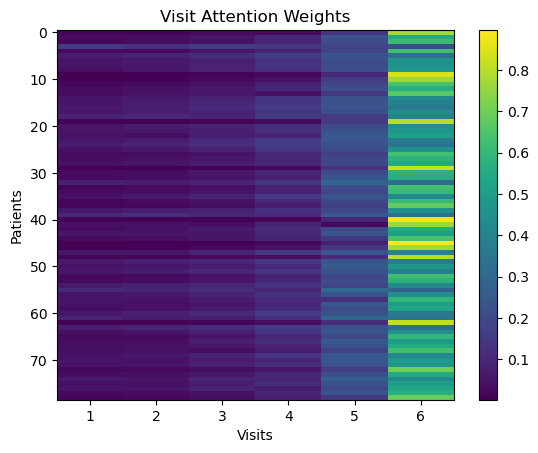

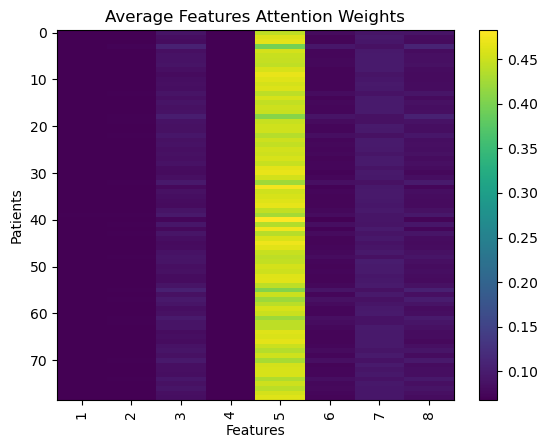

In [54]:
model = 0
if future_time_s == 1:
    longitudinal_train_data = lon_data_train[0]
    train_label = label_train[0]
    longitudinal_test_data = lon_data_test[0]
    test_label = label_test[0]
    demographic_train_data = np.array(dem_data_train[0])
    demographic_test_data = np.array(dem_data_test[0])
    train_time = time_train
    train_time = np.reshape(train_time,(train_time.shape[0], train_time.shape[1]*train_time.shape[2]))
    test_time = time_test
    test_time = np.reshape(test_time,(test_time.shape[0], test_time.shape[1]*test_time.shape[2]))

    # HP
    TA_RNN_hp_list = list(TA_RNN_hp_df.iloc[0,:])

    TARNN_metrics_results_df = create_table()
    for j in range(5):
        print("iteration_", j+1)
        #TA-RNN
        TA_RNN_result, model = do_TA_RNN(longitudinal_train_data, train_time, train_label, longitudinal_test_data, test_time, test_label, demographic_train_data,
                              demographic_test_data, j+1, future_time_s, TA_RNN_hp_list)
        TARNN_metrics_results_df = pd.concat([TARNN_metrics_results_df, TA_RNN_result], axis=1)
        print("TA-RNN")
    # SAVE RESULTS
    TA_RNN_scenario = str(time_steps)+'_'+str(future_time_s)+'_TARNN.csv'
    TARNN_metrics_results_df.to_csv(TA_RNN_scenario, index = False)
    
    visit_att, feature_att = attention_extractor(model, longitudinal_test_data, test_time, demographic_test_data)
    # plot visits attention
    vaw = np.reshape(visit_att,(visit_att.shape[0], visit_att.shape[1]*visit_att.shape[2]))
    visualize_visits_attention_weights(vaw)

    # plot features attention
    faw = np.mean(feature_att, axis=1)
    visualize_features_attention_weights(faw)
else:
    print('Number of future visit for prediction should be 1 for TA-RNN')